# Lastganganalyse

# 1. Modulimport

In [79]:
import pandas as pd
import math as m
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

#Satistik (Regression)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 
import statsmodels.api as sm

#os to check folders
import os 
import glob

#Excel:
import xlwings as xw

#Shutup
import shutup; shutup.please() #Ignoriert die Warnung, das Python nicht mit dem Dropdown aus Excel arbeiten kann

# 2. Daten aus Excel einladen 

In [80]:
#list of all files that end with .xlsx
file_list = glob.glob("*.xlsx")
file_list

['Lastgangtool-Mappe.xlsx', '~$Lastgangtool-Mappe.xlsx']

In [81]:
Excel_name = file_list[0] #gets the first excel in folder
Sheet_name = 'Eingabe'

In [82]:
wk = xw.Book(Excel_name) # Öffnen der Excel-Datei

In [83]:
sheet = wk.sheets(Sheet_name) #Öffnen der Excel-Arbeitsmappe 

In [84]:
df_data = sheet['A2'].expand().options(pd.DataFrame, chunksize=10_000).value #Einlesen des Inhalts-> Speichert alle Werte(.values) ab 'A2' als DataFrame, Chunksize = Matrixgröße

###df_data

In [85]:
Load_profile = df_data.iloc[: , [0]] # SLicing der 1. Spalte!

###Load_profile

# 3. Lösung des Mittenachtsproblems

Problem: Python gibt die letzte Stunde des Tages als 00:00 an - Datensätze mit 24:00 müssen angepasst werden

### Slicing der Spalte mit fehlerhaftem Datensatz (Zeitstempel)

In [86]:
df_timestamp  = pd.DataFrame(Load_profile.index) #Index (Zeitstempel) als Dataframe

###df_timestamp

## 3.1 Anpassung des Formats 

### Abfrage und umwandlung in Zielforamtin Zielformat: [#Y-#m-#d #H:#M ]

### Einladen des Formates

In [87]:
#tformat = sheet.range('A3').options('dict').value

In [88]:
dformat = sheet.range('F3').value
tformat = sheet.range('A3').value
tformat = str(tformat)
dformat,tformat

('#d-#m-#y #H:#M', '2020-01-01 00:15:00')

In [89]:
type (sheet.range('A3').value) == datetime.datetime # Hinweis XLWings Erkennt das Excel Datumsformt. 

True

### Abfrage des Datenformates um Trennzeichen zu definieren 

In [90]:
# 1. If abfrage ob 'datetime.datetime' Format erkannt wurde oder nicht
if type (sheet.range('A3').value) == datetime.datetime or dformat == '#y-#m-#d #H:#M' : #2020-09-02T00:37
    dformat = '#y-#m-#d #H:#M'
    Seperator = tformat[10]
    Date_sep = tformat[4]
    Time_sep = tformat[13]
    
elif dformat == '#d-#m-#y #H:#M' : #01.01.2021 00:15
    Seperator = tformat[10]
    Date_sep = tformat[2]
    Time_sep = tformat[13]
    
elif dformat == '#H:#M #y-#m-#d': #00:00 2020-03-01
    Seperator = tformat[5]
    Date_sep = tformat[10]
    Time_sep = tformat[2]
 
elif dformat == '#H:#M #d-#m-#y': #00:00K01.01.2021
    Seperator = tformat[5]
    Date_sep = tformat[8]
    Time_sep = tformat[2]    


Seperator,Date_sep,Time_sep

(' ', '-', ':')

In [91]:
dformat

'#y-#m-#d #H:#M'

### Aufteilung der Daten ! Achtung: Trenner in Split richtig Angeben!

### Splitten in Datum und Uhrzeit 

In [92]:
df_timestamp = df_timestamp.astype(str) #Umwandulung in String
df_timestamp = df_timestamp.Zeitstempel.str.split(Seperator,expand=True ) # Splitten des Timestamps in Datum und Uhrzeit 

###df_timestamp

In [93]:
if dformat == '#d-#m-#y #H:#M' or dformat == '#y-#m-#d #H:#M'  :
    df_timestampDate = df_timestamp[0].str.split(Date_sep,expand=True ) ## Splitten des Datums in Tag,Monat, JAhr 
    
elif dformat == '#H:#M #y-#m-#d' or dformat == '#H:#M #d-#m-#y': 
    df_timestampDate = df_timestamp[1].str.split(Date_sep,expand=True ) ## Splitten des Datums in Tag,Monat, JAhr
    

###df_timestampDate

### Zusammenführung der Daten

### Abfrage der Reihenfolge und Umsortierung 

In [94]:
if dformat == '#d-#m-#y #H:#M' or dformat == '#H:#M #d-#m-#y' : #01.01.2021 00:15 or #00:00K01.01.2021
    Neusortierter_timestamp = df_timestampDate[2] + '-' + df_timestampDate[1] + '-' + df_timestampDate[0]  # Zusammenfassung in einer Zelle
    df_timestamp[0]=Neusortierter_timestamp # Zusammenfassung des Datums in einer Zelle
    
elif dformat == '#H:#M #y-#m-#d' or dformat == '#y-#m-#d #H:#M': #00:00K01.01.2021 or #00:00 2020-03-01
    Neusortierter_timestamp = df_timestampDate[0] + '-' + df_timestampDate[1] + '-' + df_timestampDate[2]  # Zusammenfassung in einer Zelle
    df_timestamp[0]=Neusortierter_timestamp # Zusammenfassung des Datums in einer Zelle
    
###df_timestamp

### Zusammenfassung Datum und Uhrzeit 

In [95]:
if dformat == '#d-#m-#y #H:#M' or dformat == '#y-#m-#d #H:#M'  :
    df_timestamp = df_timestamp[0] + ' ' + df_timestamp[1] # Zusammenfassung Datum und Uhrzeit in einer Zelle
    
elif dformat == '#H:#M #y-#m-#d' or dformat == '#H:#M #d-#m-#y': 
    df_timestamp = df_timestamp[1] + ' ' + df_timestamp[0] # Zusammenfassung Datum und Uhrzeit in einer Zelle
    

###df_timestamp

## 3.2 Austausch der 24. Stunde und Umwandlung in datetime24

In [96]:
df_timestamp = pd.DataFrame (df_timestamp) #Erstellung eines Dataframes      EINGABE EINER SERIES!
df_timestamp.columns = ['Zeitstempel'] #Änderung des Namens der Column
df_timestamp = df_timestamp.astype(str) # Umwandlung der Daten im Dataframe zu Strings
df_timestamp2 = df_timestamp.Zeitstempel.str.split(" ",expand=True ) # Splitten des Timestamps in Datum und Uhrzeit 
df_timestamp2.loc[df_timestamp2[1] == "24:00", 0] = pd.to_datetime(df_timestamp2[0])+pd.Timedelta('1 day') #Erhöhung der Tage um 1 wenn diese den Studnenwert 24 besitzen
df_timestamp2 = df_timestamp2.replace('24:00','00:00')  # Ersetzen der 24. Stunde mit der 00. Stunde!!     RICHTIGES FORMAT??
df_timestamp2 = df_timestamp2.astype(str) # Umwandlung in String 
s_timestamp = df_timestamp2[0].str[:10] + ' ' + df_timestamp2[1] #Zusammenführung der Strings und ignorieren der 00:00:00 bei den um 1 erhöten Tagen 
s_timestamp = pd.to_datetime(s_timestamp) # Umwandlung des Datentyp von String in datetime64 Und Angabe des eingabe Formates!!!
df_timestamp = pd.DataFrame (s_timestamp, columns = ['Zeitstempel']) # Umwandlung in einen DataFrame


###df_timestamp

Erstezen des Splalte im Ausgangs Dataframe 

# 3.3  EingabeIndex mit geändertem Index überschrieben 

In [97]:
Load_profile = Load_profile.reset_index() #Index zurücksetzen-> somit wird dieser als Spalte abgespeichert!

In [98]:
Load_profile['Zeitstempel'] = df_timestamp #Austatsuch des Alten Indexes mit dem neuen

# 4. Zeitumstellungsproblem

Bei der Zeitumstellung kann es Vorkommen das Werte doppelt vorliegen oder das diese Fehlen, diese Problem wird hier gelöst

### 4.1 Einheiten des Lastgangs einlesen

In [99]:
Energie_Unit = sheet.range('C3').value
Zeit_Unit = sheet.range('D3').value
Aggregation_Unit = sheet.range('E3').value

Energie_Unit,Zeit_Unit,Aggregation_Unit

('kWh', 'Viertelstunde', None)

Definieren der Einheiten

## 4.2 Erstellung eines korrekten  Zeitstempels 

### Startzeit definieren 

In [100]:
Start_Time = pd.Series.to_string (Load_profile.loc[:0,'Zeitstempel'], index=False)
Starting_Time = pd.to_datetime(Start_Time) #Staretzeit für Index definieren als datetime64 
Starting_Time

Timestamp('2020-01-01 00:15:00')

### Endzeit definieren

In [101]:
Ending_Time = Load_profile.iloc[ -1, 0]

###Ending_Time

### Abfrage der Einheit und  Intervalls des Lastgangs

In [102]:
if Zeit_Unit == 'Viertelstunde':
    Unit = 'm'
    Step = 15

elif Zeit_Unit == 'Tage':
    Unit = 'D'
    Step = 1
    
else: 
    Unit = 'h'
    Step = 1
    
##Unit, Step

### Funktion definieren um die korrekte Zeitreihe zu erstellen 

In [103]:
def new_timestamp ( Starting_Time, Ending_Time, Step , Unit ): #Unit can be (D)ay, (M)onth, (Y)ear, (h)ours, (m)inutes, or (s)econds
    '''
    gibt ein Array mit Stundenwerten im gegebenen Rahmen aus 
    '''
    Index = np.arange( np.datetime64(Starting_Time), np.datetime64(Ending_Time)+np.timedelta64(Step,Unit) , np.timedelta64(Step,Unit) ,dtype='datetime64[s]')

    return Index

In [104]:
Starting_Time, Ending_Time, Step , Unit

(Timestamp('2020-01-01 00:15:00'), Timestamp('2022-05-30 23:45:00'), 15, 'm')

### Ausführung der Funktion -> korrekte Zeitreihe

In [105]:
korrect_timestamp = new_timestamp ( Starting_Time, Ending_Time, Step , Unit )

##korrect_timestamp

In [106]:
len(korrect_timestamp)

84575

### Umwandlung in Dataframe

In [107]:
korrect_timestamp = pd.DataFrame(korrect_timestamp,columns = ['Zeitstempel'])
korrect_timestamp = korrect_timestamp.set_index('Zeitstempel')

###korrect_timestamp

## 4.3 Zuordnung der gemessenen Daten zum korrekten Zeitstempel

### Zuordnung der Lastgangdaten zum korrekten Zeitstempel

In [108]:
Load_profile =Load_profile.set_index('Zeitstempel') #Neuer ZEitstempel als Index

In [109]:
Load_profile = korrect_timestamp.join(Load_profile)

#Load_profile

## 4.4 Datum löschen welches dopplet vorkommen (Zeitumstellung)

In [110]:
#convert index to list
index_list = list(Load_profile.index.values)

##index_list

In [111]:
index_Series= pd.Series(index_list) #Als Series umwandeln

index_Series = index_Series.astype(str) #Umwandlung als String

##index_Series.rename ( 'DoubleIndex')

#### Kopie des Indexes als neue Spalte

In [112]:
Load_profile = Load_profile.assign(DoubleIndex = index_list)

##Load_profile

###  Löschen von Zeilen in denen 'DoubleIndex' mehrfach vorkommt 

In [113]:
Load_profile = Load_profile.drop_duplicates(subset='DoubleIndex', keep= 'first')

Entfernen der Spalte DoubleIndexes

In [114]:
Load_profile = pd.DataFrame(Load_profile['Lastgang'])

##Load_profile

## 4.5 lineare Interpolieren von Werten Die nicht vorhanden sind 

In [115]:
Load_profile = Load_profile.interpolate(method='linear', limit_direction='forward', axis=0)
Load_profile_ready = Load_profile
##Load_profile

# Lastgang ist nun Aufbereitet !

#

## 5. Umrechnen des Lastgangs

## 5.2 Umrechnung der Einheiten 

### Definieren von Sets mit Umrechnungsfaktoren 

In [116]:
## Umrechnungs Faktoren
convert_hour = {'kW': 1,
                'kWh': 1,
                'W': 1000,
                'Wh':1000,
                'm3/h': 1/9.77,
                'm3': 1/9.77} #dict damit dieses Erweitert werden kann

convert_quater_hour = {'kW': 4,
                       'kWh': 1,
                       'W': 4000,
                       'Wh': 1000,
                       'm3/h': 4/9.77,
                       'm3': 1/9.77}

## Funktion definieren um den Lastgang in kW pro Stunde umzurechnen -> kWh !!!

In [117]:
def convert_units (Load, Unit, Timestemp, convert_hour, convert_quater_hour):
    '''
    Umrechnung des Lastgangs in kW pro Stunde mit Umrechnungsfaktoren aus den dicts convert_hour, convert_quater_hour
    '''
    if Timestemp == 'Stunden':      #Abfrage Zeitstempel
        x = Load / convert_hour[Unit] #Lastgang durch Faktor
        
    else:
        x = Load / convert_quater_hour[Unit]

    return x.round(decimals=10) #Runden einer Series auf 2 Nachkommastellen und Ausgabe 

### Anwenden der Funktion 

In [118]:
Load_profile = convert_units (Load_profile, Energie_Unit, Zeit_Unit, convert_hour, convert_quater_hour)

##Load_profile

In [119]:
Load_profile.sum()

Lastgang    5335230.074
dtype: float64

# 5.1 Aggreagtion der Zeit 

## Berechnung für Tage und Monate Woche 

In [120]:
Load = Load_profile
Load

,Lastgang
Zeitstempel,
2020-01-01 00:15:00,22.290
2020-01-01 00:30:00,23.040
2020-01-01 00:45:00,23.250
2020-01-01 01:00:00,22.950
2020-01-01 01:15:00,23.410
...,...
2022-05-30 22:45:00,84.680
2022-05-30 23:00:00,78.193
2022-05-30 23:15:00,79.744


# Aggegationen 

# Stundenlastgang

In [121]:
#Summiert alle Werte an denen Jahr, Monat, Tag und Stunde gleich ist :) 
Hour_Load = Load.groupby(by=[Load.index.map(lambda x : (x.year, x.month, x.day, x.hour))]).agg({'Lastgang': 'sum'})

###Hour_Load

In [122]:
#Change index to datetime format
a = pd.DataFrame(Hour_Load.index.values.tolist(), columns=['year','month','day','hour'])
Hour_Load.index = pd.to_datetime(a)

###Hour_Load

# Tageslastgang

In [123]:
Day_Load = Load.groupby(Load.index.date).agg({'Lastgang': 'sum'})

###Day_Load

In [124]:
Day_Load = Day_Load.reset_index()

# Wochenlastgang

In [125]:
Week_Load = Load.groupby(by=[Load.index.map(lambda x : (x.year, x.week))]).agg({'Lastgang': 'sum'})

###Week_Load

In [126]:
Week_Load = Week_Load.reset_index(drop = True) #Index entfernen 
Week_Load['Zeitstempel'] = pd.Series (new_timestamp ( Starting_Time, Ending_Time, 7 , 'D' )) # neuen Zeitstempel hinzufügen

###Week_Load 

# Monatslastgang 

In [127]:
Month_Load = Load.groupby(by=[Load.index.map(lambda x : (x.year, x.month))]).agg({'Lastgang': 'sum'})
Month_Load = Month_Load.reset_index(drop= True)
Month_Load['Zeitstempel'] = pd.Series (np.arange(Starting_Time, ( np.datetime64(Ending_Time,'M')+np.timedelta64(1,'M') ),dtype='datetime64[M]'))
###Month_Load

##### Test ob die Summen gleich bleiben 

In [128]:
Hour_Load['Lastgang'].sum()== Day_Load['Lastgang'].sum() == Month_Load['Lastgang'].sum() == round(Week_Load['Lastgang'].sum(),1)

False

In [129]:
Hour_Load['Lastgang'].sum()

5335230.074000001

In [130]:
Day_Load['Lastgang'].sum()

5335230.074

In [131]:
Month_Load['Lastgang'].sum()

5335230.073999999

In [132]:
Week_Load['Lastgang'].sum()

5335230.074

# 6. Darstellung erstellen 

# !!!Aufgabe:Flächendiagramm mit Grund und Spitzenlast 

In [133]:
#Load_profile

### Erstellen einer Series mit dem Zeitstempel

In [134]:
index_list = list(Load_profile.index.values)
index_Series= pd.Series(index_list) #Als Series umwandeln
index_Series = index_Series.astype(str) #Umwandlung als String

#index_Series

 ### Erstellt eine Series mit dem Lastgang

In [135]:
Load = Load_profile.loc[:,'Lastgang'] 

#Load

In [136]:
size = np.arange(len (Load))

In [137]:
#size

### Grundlast

In [138]:
Load_profile.min()[0]

0.0

In [139]:
df = sheet.range('F6').value = Load_profile.min()[0]
df = sheet.range('F5').value = 'Grundlast'

### Spitzenlast

In [140]:
df = sheet.range('G6').value = Load_profile.max()[0]
df = sheet.range('G5').value = 'Spitzenlast'

### Grund- und Spitzenlast als Splate erstellen 

In [141]:
Load_profile['Grundlast'] = np.full((len(Load_profile)),Load_profile.min()[0]) #Erstellte eine Spalte die nur die Grundlast enthhält

Load_profile['Spitzenlast'] = np.full((len(Load_profile)),Load_profile.max()[0]) #Erstellte eine Spalte die nur die Spitzenlast enthält



### Lineplot erstellen mit Ausgangslastgang

<Picture 'LOAD' in <Sheet [Lastgangtool-Mappe.xlsx]Eingabe>>

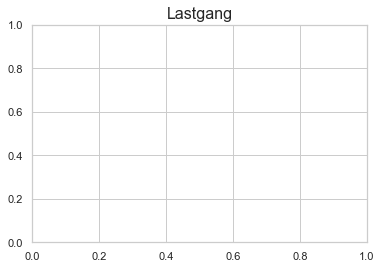

In [142]:
sns.set_theme(style="whitegrid")
sns.despine(left=True)
plt.title('Lastgang', fontsize = 16) #Titel definieren 

fig = plt.figure(figsize=(14,8))
plot = sns.lineplot(data=Load_profile['Lastgang'], palette="tab10", linewidth=0.8 ,label=('Lastgang')) #Plot erstellen 
plot = sns.lineplot(data=Load_profile['Grundlast'], palette="tab10", linewidth=2, label=('Grundlast') ) #Plot erstellen 
plot = sns.lineplot(data=Load_profile['Spitzenlast'], palette="tab10", linewidth=2, label=('Spitzenlast')) #Plot erstellen 

plot.legend( fontsize = 24)
plot.set_xlabel("Zeit", fontsize = 16) #Beschreibung X-Achse & Schriftgröße
plot.set_ylabel("[kWh]", fontsize = 16) #Beschreibung Y-Achse & Schriftgröße
#plot = sns.relplot(x='Zeitstempel', y="Lastgang", kind="line", data=Load_profile, height=20, aspect=1.8)

sheet.pictures.add(fig, name='LOAD', update=True, left=sheet.range('D10').left, top=sheet.range('D10').top) #Speichern in Excel

###g.figure.autofmt_xdate() #Automatisches Labeln der x Achse 

In [143]:
Hour_Load

,Lastgang
2020-01-01 00:00:00,68.580
2020-01-01 01:00:00,92.180
2020-01-01 02:00:00,94.000
2020-01-01 03:00:00,96.830
2020-01-01 04:00:00,94.920
...,...
2022-05-30 19:00:00,324.727
2022-05-30 20:00:00,326.391
2022-05-30 21:00:00,329.216
2022-05-30 22:00:00,333.479


### Hour_Load graphics

In [144]:
#Hour_Load = Hour_Load.set_index('Zeitstempel') #set time to index
Hour_Load['Grundlast'] = np.full((len(Hour_Load)),Hour_Load.min()[0]) #ne column only with the base load
#Hour_Load

In [145]:
Hload_min = pd.DataFrame({'Grundlast_Datum':[Hour_Load['Lastgang'].min()] , 'Zeitstempel': [Hour_Load['Lastgang'].idxmin()] }) #creates a new column onlie with the base values
Hload_min = Hload_min.set_index('Zeitstempel') #sets index 
#Hload_min

In [146]:
Hload_max = pd.DataFrame({'Spitzenlast':[Hour_Load['Lastgang'].max()] , 'Zeitstempel': [Hour_Load['Lastgang'].idxmax()] })
Hload_max = Hload_max.set_index('Zeitstempel')
#Hload_max

In [147]:
# Join to Hour load

Hour_Load = Hour_Load.join(Hload_max) 
Hour_Load = Hour_Load.join(Hload_min)
#Hour_Load

## Create a folder when not exist to save html pots

In [148]:
#os to check path

if not os.path.exists("Plots"): #if there is no folder create a new one
    os.mkdir("Plots")

## Plotly Graph

In [149]:
import plotly.graph_objects as go
#from kaleido.scopes.plotly import PlotlyScope

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=Hour_Load.index, y =  Hour_Load['Lastgang'], #x an y labels by data
                    mode='lines', #can be lines, makers, or lines+makers
                    name='Lastgang',#name of label
                    line=dict(
                        color='darkgreen', #line color 
                        width=2,) #line width)

            ))

fig.add_trace(go.Scatter(x=Hour_Load.index, y =  Hour_Load['Spitzenlast'],
                    mode='markers',
                    name='Spitzenlast',#name of label
                    marker_symbol= 'square-dot' , # symbol names:https://plotly.com/python/marker-style/
                    marker=dict(
                        color='red', #maker color
                        size=10,     #maker size
                        line=dict(
                            color='black', #maker linecolor
                            width=3 ))  #maker linesize
            ))

fig.add_trace(go.Scatter(x=Hour_Load.index, y =  Hour_Load['Grundlast'],
                    mode='lines',
                    name='Grundlast',#name of label
                    line=dict(
                        color='orange', #line color 
                        width=3, #line width
                        ) 
            ))

fig.add_trace(go.Scatter(x=Hour_Load.index, y =  Hour_Load['Grundlast_Datum'],
                    mode='markers',
                    name='Grundlast_Tag',#name of label
                    marker_symbol= 'arrow-up' ,
                    marker=dict(
                        color='orange', #maker color
                        size=13 )
                        )
)


fig.update_yaxes(title_text="[kW]",
                ) # name of y-label

fig.update_layout( # customize font and legend orientation & position
    font_family="Arial", #Change font
    font=dict(size=16), #Change font size
    width=1080, height=720, #Change fig size
    title= None,  #Set diagramm title
    template="none", #set a tamplate [simple_white,ggplot2,seaborn,none,plotly_dark]
    margin = dict(l=85, r=35, b=50, t=85), #Change margins
    
    legend=dict(
        title=None, 
        orientation="h",    # position of Labels vertival: 'v', horizontal: 'h'
        y=1.05 , yanchor="bottom", # float for distance  ,  y oriantation of Labels ['auto', 'top', 'middle', 'bottom']
        x=0.5, xanchor="auto",   # float for distance  , y oriantation of Labels ['auto', 'left', 'center', 'right']
        #font=dict(size=16)
    )
    
    )

#Save fig as html file

fig.write_html(f"Plots/{Excel_name}_Load_hourly.html")


# Save fig to exle - - - this doesn't work cause you need xlwings pro!!
#Sheet_name2 = 'A_Stunden'
#sheet2 = wk.sheets(Sheet_name2)
#sheet2.pictures.add(fig, name='LOAD', update=True, left=sheet.range('D10').left, top=sheet.range('D10').top) #Speichern in Excel

In [150]:
#sns.displot(tips['tip'], kde = True, bins=20)
#sns.displot(Load_profile["Lastgang"],  kde = False, bins=8760, height=10, aspect=1.8)

In [151]:
#sns.displot(data=Load_profile,x='Zeitstempel', y="Lastgang", multiple="stack",kind="kde")

# !!!Aufgabe: Jahresdauerlinie

### !!Wenn mehrere Jahre vorhanden sind Auswahl über die das Betrachtungsjahr einbauen 

### Create a list of all given years 

In [152]:
first_year  = Hour_Load.index[1].year
last_year = Hour_Load.index[-1].year

all_years = [i+1 for i in range (first_year-1 ,last_year) ]
all_years

[2020, 2021, 2022]

## Create a Dataframe with sorted values for every given year

In [153]:
lenght = [len(Hour_Load[Hour_Load['Lastgang'].index.year == i]) for i in all_years ] # get longest year -> leap year 
annual_lines = pd.DataFrame(np.arange( max(lenght) )).set_index(0)          #creat an array with all hours in year with max years    
annual_lines['Jahresstunden'] = pd.DataFrame(np.arange((max(lenght)),0,-1)) #create a new dataframe to save while iterating

H_Load = Hour_Load['Lastgang']

for i in all_years:
    H_LoadY = H_Load[H_Load.index.year == i] #slice index by year 
    H_LoadY = H_LoadY.sort_values(ascending=True) #Sort data - smalest first 
    H_LoadY = H_LoadY.reset_index(drop=True)     #drop index
    annual_lines[f'Lastgang{i}'] = H_LoadY

#annual_lines

In [154]:
fig = go.Figure()

# Add traces
for i in all_years:
    fig.add_trace(go.Scatter(y=annual_lines[f'Lastgang{i}'], x =  annual_lines['Jahresstunden'], #x an y labels by data
                        mode='lines', #can be lines, makers, or lines+makers
                        name=f'Lastgang{i}'#name of label




) ) 

fig.update_yaxes(title_text="Leistung [kW]",
                ) # name of y-label

fig.update_xaxes(title_text="Anzahle Stunden",
                ) # name of x-label

fig.update_layout( # customize font and legend orientation & position
    font_family="Arial", #Change font
    font=dict(size=16), #Change font size
    width=1080, height=720, #Change fig size
    title= None,  #Set diagramm title
    template="none", #set a tamplate [simple_white,ggplot2,seaborn,none,plotly_dark]
    margin = dict(l=85, r=35, b=50, t=85), #Change margins
    #separators = ', ', #change seperator for dezimal sep
 

    

    legend=dict(
        title=None, 
        orientation="h",    # position of Labels vertival: 'v', horizontal: 'h'
        y=1.05 , yanchor="bottom", # float for distance  ,  y oriantation of Labels ['auto', 'top', 'middle', 'bottom']
        x=0.5, xanchor="auto",   # float for distance  , y oriantation of Labels ['auto', 'left', 'center', 'right']
        #font=dict(size=16)
    ))

    #Save fig as html file

fig.write_html(f"Plots/{Excel_name}_annual_line.html")



# !!!Aufgabe: Spitzenlasttag

### !!Tag mit Spitzenlast herrausfinden 
datum als suche für den Tag nutzen 
Tag als diagramm darstellen

# !!!Aufgabe: Heatmap (Spektarlanalyse)

### !!Neuen Dataframe erstellen Index = alle Viertelstunden eines Tages -> Columns = jeder Tag des Jahres

# !!! Augabe: Wochentagmittel 

### Welche art des Mittelwertes? 


# !!! Aufgabe Boxplotdarstellung

# !!! Aufgabe: Ergebnisse in Excel abspeichern Auch Grafiken!

### 1. Mappe = aufbereiteter Ausgangslastgang
 2. Mappe = auf Monate aggregiert
 3. Mappe = auf Wochen aggregiert
 4. Mappe = auf Tage aggregiert
 5. Mappe = auf Stunden aggregiert 
 6. Mappe = Darstellung der Spktralanalyse mit Werten 

 Weitere Mappen mit den Oben stehenden Diagrammen 

In [155]:
#wk = xw.Book(Excel_name) # Öffnen der Excel 

sheet = wk.sheets('A_Lastgang') #Öffnen der Excel-Arbeitsmappe 
df = sheet.range('A1').value = Load_profile_ready
df = sheet.range('A1').value = '[' + Energie_Unit +']'

sheet = wk.sheets('A_Stunden') #Öffnen der Excel-Arbeitsmappe 
df = sheet.range('A1').value = Hour_Load
df = sheet.range('A1').value = '[kWh]'

sheet = wk.sheets('A_Tage') #Öffnen der Excel-Arbeitsmappe 
df = sheet.range('A1').value = Day_Load
df = sheet.range('A1').value = '[kWh]'

sheet = wk.sheets('A_Wochen') #Öffnen der Excel-Arbeitsmappe 
df = sheet.range('A1').value = Week_Load
df = sheet.range('A1').value = '[kWh]'

sheet = wk.sheets('A_Monate') #Öffnen der Excel-Arbeitsmappe 
df = sheet.range('A1').value = Month_Load
df = sheet.range('A1').value = '[kWh]'

wk.close

<bound method Book.close of <Book [Lastgangtool-Mappe.xlsx]>>

# !!!Aufgabe Veröffentlichen als .exe -Datei und in Abteilung vorstellen 

# !!!Nächster Schritt -> Aufgabe: GUI mit pyqt5  

### Arten der Filterung: Tag, Wochenenden, Wochentage, 

### !!erstellen mit Upload möglichkeit von excel und csv Datein Graphische ausgabe mit der Möglichkeit auszuwählen welche diagramme und Tabbellen gespeichert werden sollen

# !!!Aufgabe: Regression mit Wetterdaten sowie Klimabereinigung 

###  !!einlesen von Klimadaten oder noch besser auswahl eines Standort und automatisches einlesen der Klimadaten (Downlod deutscher Wetterdienst)

### !!Regression mit Ausgabe des Einflusses durch R^2

### !!Klimabereinigung des eingeladenen Lastganges mit Wetterdaten 

### Spitzenlast reduktion mit monetären abschätzung (Preisstaffelung)

### Branchen vergleich mit SLP